In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf


#Modélisation
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


In [2]:
import os
import pandas as pd

train_dir = 'C:\\Users\\sidda\\did\\train'

# Create empty list to store data
train_data = []

# Add image paths and labels to the list
for label, folder_name in enumerate(["Acne and Rosacea Photos","Bullous Disease Photos","Cellulitis Impetigo and other Bacterial Infections","Eczema Photos","Warts Molluscum and other Viral Infections"]):
    for filename in os.listdir(os.path.join(train_dir, folder_name)):
        image_path = os.path.join(train_dir, folder_name, filename)
        train_data.append({'image_path': image_path, 'label': label})

# Create dataframe from the list
train_df = pd.DataFrame(train_data)

# Display the dataframe
print(train_df)


                                             image_path  label
0     C:\Users\sidda\did\train\Acne and Rosacea Phot...      0
1     C:\Users\sidda\did\train\Acne and Rosacea Phot...      0
2     C:\Users\sidda\did\train\Acne and Rosacea Phot...      0
3     C:\Users\sidda\did\train\Acne and Rosacea Phot...      0
4     C:\Users\sidda\did\train\Acne and Rosacea Phot...      0
...                                                 ...    ...
3892  C:\Users\sidda\did\train\Warts Molluscum and o...      4
3893  C:\Users\sidda\did\train\Warts Molluscum and o...      4
3894  C:\Users\sidda\did\train\Warts Molluscum and o...      4
3895  C:\Users\sidda\did\train\Warts Molluscum and o...      4
3896  C:\Users\sidda\did\train\Warts Molluscum and o...      4

[3897 rows x 2 columns]


In [3]:
# Get list of directories in train_dir
labels = ["Acne and Rosacea Photos","Bullous Disease Photos","Cellulitis Impetigo and other Bacterial Infections","Eczema Photos","Warts Molluscum and other Viral Infections"]

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'Acne and Rosacea Photos',
 1: 'Bullous Disease Photos',
 2: 'Cellulitis Impetigo and other Bacterial Infections',
 3: 'Eczema Photos',
 4: 'Warts Molluscum and other Viral Infections'}

In [4]:
df = train_df
max_images_per_class = 3250

df = df.groupby("label", group_keys=False).apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

In [5]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

12

In [7]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

In [8]:
df.head()

,image_path,label,image
0,C:\Users\sidda\did\train\Acne and Rosacea Phot...,0,"[[[160, 125, 119], [160, 125, 120], [157, 121,..."
1,C:\Users\sidda\did\train\Acne and Rosacea Phot...,0,"[[[164, 130, 126], [159, 125, 119], [153, 120,..."
2,C:\Users\sidda\did\train\Acne and Rosacea Phot...,0,"[[[222, 162, 158], [221, 159, 158], [217, 150,..."
3,C:\Users\sidda\did\train\Acne and Rosacea Phot...,0,"[[[93, 68, 63], [89, 65, 58], [96, 68, 59], [1..."
4,C:\Users\sidda\did\train\Acne and Rosacea Phot...,0,"[[[17, 12, 9], [25, 19, 16], [27, 19, 15], [19..."


In [9]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [10]:
# Create an empty list to store the augmented images
augmented_data = []

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        # Apply transformations to the selected images and add them to the augmented data list
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Extract the augmented image arrays and add them to the augmented data list
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_data.append({'image_path': None, 'label': class_label, 'image': augmented_image_array})
    
    # Add the original images for the current class to the augmented data list
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_data.extend(original_images_df.to_dict('records'))

# Create a new DataFrame from the augmented data list
df = pd.DataFrame(augmented_data)

# Group the augmented DataFrame by the 'label' column and filter out extra images
df = df.groupby('label').head(max_images_per_class)

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,image_path,label,image
0,None,0,"[[[135, 106, 101], [130, 103, 100], [128, 101,..."
1,None,4,"[[[85, 41, 35], [85, 41, 35], [85, 41, 35], [8..."
2,C:\Users\sidda\did\train\Eczema Photos\eczema-...,3,"[[[31, 21, 21], [38, 28, 28], [42, 32, 33], [3..."
3,None,0,"[[[50, 38, 48], [49, 37, 47], [55, 42, 54], [6..."
4,C:\Users\sidda\did\train\Eczema Photos\eczema-...,3,"[[[21, 12, 15], [21, 12, 15], [22, 15, 17], [2..."
...,...,...,...
16245,None,4,"[[[207, 172, 162], [206, 170, 160], [206, 170,..."
16246,None,1,"[[[22, 22, 24], [22, 22, 24], [21, 21, 24], [2..."
16247,None,0,"[[[12, 7, 3], [14, 7, 3], [15, 7, 4], [14, 7, ..."
16248,C:\Users\sidda\did\train\Warts Molluscum and o...,4,"[[[95, 77, 103], [99, 78, 105], [102, 78, 104]..."


In [11]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [12]:
features.head()

,image
0,"[[[135, 106, 101], [130, 103, 100], [128, 101,..."
1,"[[[85, 41, 35], [85, 41, 35], [85, 41, 35], [8..."
2,"[[[31, 21, 21], [38, 28, 28], [42, 32, 33], [3..."
3,"[[[50, 38, 48], [49, 37, 47], [55, 42, 54], [6..."
4,"[[[21, 12, 15], [21, 12, 15], [22, 15, 17], [2..."


In [13]:
target.head()

0    0
1    4
2    3
3    0
4    3
Name: label, dtype: int64

In [14]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [15]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [16]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [17]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [18]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [19]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [20]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               Acne and Rosacea Photos        2066       539          645        3250      
1               Bullous Disease Photos         2078       524          648        3250      
2               Cellulitis Impetigo and other Bacterial Infections 2053       512          685        3250      
3               Eczema Photos                  2108       517          625        3250      
4               Warts Molluscum and other Viral Infections 2095       508          647        3250      
------------------------------------------------------------------------------------------
Total                                          10400      2600         3250       16250     


In [23]:
df.groupby('label').size()

label
0    3250
1    3250
2    3250
3    3250
4    3250
dtype: int64

In [24]:
input_shape = df['image'][0].shape

In [23]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# DenseNet121
model = Sequential()
model.add(DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [26]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [25]:
epochs = 70
batch_size=15
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction,shuffle=True)

Epoch 1/70
694/694 [==============================] - 141s 166ms/step - loss: 1.3089 - accuracy: 0.4841 - val_loss: 0.9816 - val_accuracy: 0.6269 - lr: 0.0010
Epoch 2/70
694/694 [==============================] - 103s 149ms/step - loss: 0.8588 - accuracy: 0.6787 - val_loss: 0.7940 - val_accuracy: 0.7104 - lr: 0.0010
Epoch 3/70
694/694 [==============================] - 104s 150ms/step - loss: 0.5987 - accuracy: 0.7810 - val_loss: 0.6625 - val_accuracy: 0.7715 - lr: 0.0010
Epoch 4/70
694/694 [==============================] - 104s 149ms/step - loss: 0.4282 - accuracy: 0.8484 - val_loss: 0.5755 - val_accuracy: 0.8050 - lr: 0.0010
Epoch 5/70
694/694 [==============================] - 104s 149ms/step - loss: 0.3217 - accuracy: 0.8885 - val_loss: 0.5488 - val_accuracy: 0.8312 - lr: 0.0010
Epoch 6/70
694/694 [==============================] - 103s 149ms/step - loss: 0.2595 - accuracy: 0.9065 - val_loss: 0.6022 - val_accuracy: 0.8212 - lr: 0.0010
Epoch 7/70
694/694 [==========================

In [26]:
model.save("skinDiseaseDetectionUsningCNN18.h5")

In [27]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

102/102 [==============================] - 13s 83ms/step - loss: 0.3683 - accuracy: 0.9222
Testing: accuracy = 0.922154  ;  loss = 0.368263


102/102 [==============================] - 7s 56ms/step


<Axes: >

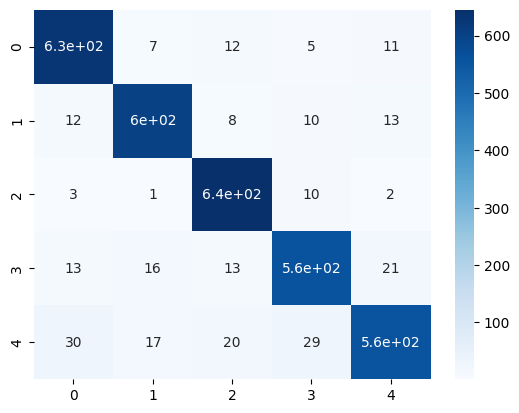

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.9222
Precision: 0.9221
Recall: 0.9218
F1-score: 0.9215
Kappa score: 0.9027


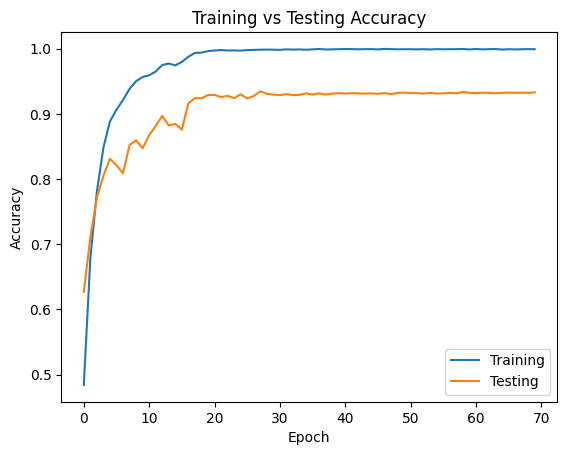

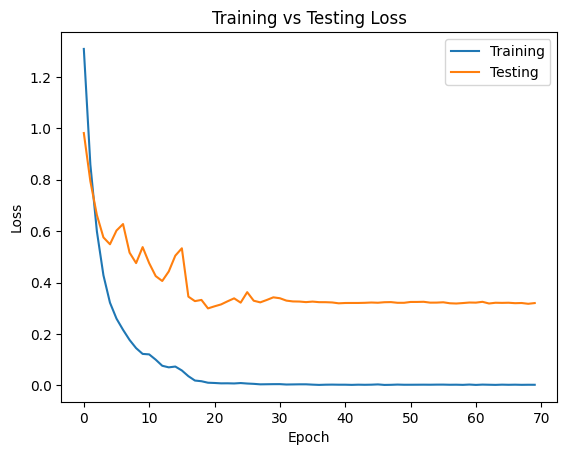

In [30]:
import matplotlib.pyplot as plt

# Get training and testing accuracy and loss histories
training_accuracy = history.history['accuracy']
testing_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
testing_loss = history.history['val_loss']

# Plot training and testing accuracy curves
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.title('Training vs Testing Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='lower right')
plt.show()

# Plot training and testing loss curves
plt.plot(training_loss)
plt.plot(testing_loss)
plt.title('Training vs Testing Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='upper right')
plt.show()

In [31]:
from tensorflow.keras.models import load_model

model_path = 'skinDiseaseDetectionUsningCNN5.h5'
  # Replace with the actual path to your model file

model = load_model(model_path)

In [29]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

102/102 [==============================] - 2s 16ms/step - loss: 1.3205 - accuracy: 0.4600
Testing: accuracy = 0.460000  ;  loss = 1.320471
